In [3]:
import numpy as np

推論（前伝播）の時に使う部分的レイヤ（paramsリスト, forwardメソッド）とモデル

In [4]:
# 全結合層関数（Affine）: 入力Xにその値の重要度を示すWを掛け合わせて,出力のしやすさを決定するbとの差で出力を求める関数
# e.g Wが大きければ、xがちょっとした値でも簡単に大きな出力の値が出されようとする
# e.g それに対しbが大きな負の値だと、いくらWXが大きな値を出してもbによってかき消されて出力が小さくなる（逆にbがWXをアシストすることもある）
# この出力が０より大きいなら出力１、０以下なら出力０とするのがパーセプトロン（以下の活性化関数の説明につながる）
class Affine:
    def __init__(self, W, b):
        self.params = [W, b] #レイヤ作成時に重みパラメータ初期値をセット、前伝播で使用（モデルに呼び出して更新する時使う）

    def forward(self, x):
        W, b = self.params
        out = np.dot(x, W) + b

        return out

In [5]:
# 活性化関数：線形な全結合層の出力を非線形にすることでNNの表現力を増やす（曲線にして柔軟なデータの境界線を作れる）
# パーセプトロン（全結合層）の線形w1*x1+w2*x2+b<=0なら出力０、w1*x1+w2*x2+b>0なら出力1で「重要」か「非重要」の２つに振り切って（発火）しか表現できなかった
# その値を活性化関数に入力することで0から1までの連続的な数値を出力して、「重要度」で示せるようになった（表現力が増した）
# 入力が重要であれば大きな値（１に近い）、重要でなければ小さな値（0に近い）を出力

class sigmoid:
    def __init__(self):
        self.params = [] # sigmoidでは実際は学習するパラメータはないが一貫性のため空のリスト

    # 0から１で入力xに対する重要度を出力
    def forward(self, x):
        return 1 / (1 + np.exp(-x))

In [6]:
# モデル（推論で使う部分のみ）
class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size):
        # ネットワーク作成時各レイヤのニューロン数を指定し初期化
        I, H, O = input_size, hidden_size, output_size

        # ランダムなパラメータ初期値
        W1 = np.random.randn(I, H)
        b1 = np.random.randn(H)
        W2 = np.random.randn(H, O)
        b2 = np.random.randn(O)

        self.layers = [
            Affine(W1, b1), #まずは入力Xを使って線形出力
            sigmoid(), # その線形出力に応じて重要度を0から1で表現（非線形）
            Affine(W2, b2) # さらにそれを入力として再び線形出力（スコア：最大スコアが判別結果になる）
        ]

        #各レイヤに格納されているモデルに呼び出してパラメータを一つのリストにまとめる（一斉に更新するため）
        self.params = []
        for layer in self.layers:
            self.params += layer.params # e.g. [W1(2,3), b1(3,), W2(4,3), b2(3,)]
        print("paramsのリストの内容:")
        for i in range (len(self.params)):
            print("self.params", [i], ":")
            print(self.params[i])

    # 入力xに対して前伝播で出力を求める（推論）
    def predict(self, x):
        for layer in self.layers:
            x = layer.forward(x)

        return x

In [7]:
# 推論の仕方
x = np.random.rand(10, 2) # 10個の２次元入力データ
model = TwoLayerNet(2, 4, 3) # ネットワーク作成時各レイヤのニューロン数を指定しモデルのインスタンス作成
s = model.predict(x) # モデルに入力データに対し推論してもらう
print("推論結果（スコア）:") # 粗zれぞれの行で一番高いスコアが判別クラスの結果
print(s)

paramsのリストの内容:
self.params [0] :
[[-0.68392689 -1.12334987 -2.22000738 -0.50284124]
 [ 0.87944245 -1.44664165 -0.00911354  2.20911881]]
self.params [1] :
[-1.62870734  1.25057461  0.3317316  -0.34679798]
self.params [2] :
[[-1.34491722 -1.91859493  0.33389382]
 [ 0.18019071  0.57339878 -0.60834375]
 [-0.91556646 -0.28379406 -0.59250841]
 [ 0.08902798  0.51797386  0.98727816]]
self.params [3] :
[-0.71082086 -0.04941252 -1.56211517]
推論結果（スコア）:
[[-0.94166675  0.12691635 -1.11441999]
 [-0.98427824  0.10701425 -1.07310988]
 [-1.04696126  0.16328404 -1.56092317]
 [-1.20660508  0.12948483 -1.63774632]
 [-1.06540013  0.13425377 -1.37694889]
 [-0.96376008  0.14645316 -1.28756461]
 [-1.12254374  0.1618769  -1.72111699]
 [-1.21792816 -0.00205507 -1.06825288]
 [-0.87789398  0.18458793 -1.52053961]
 [-1.25420619  0.13490608 -1.83234258]]


学習（逆伝播）も含めたレイヤ(gradsリスト, backwardメソッド)と更新、モデル

In [8]:
class Affine:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)] # 勾配：重みパラメータと同じ配列で初期化(逆伝播で求める)
        self.x = None #前伝播で使った入力xをクラスに保存し逆伝播で再利用する

    def forward(self, x):
        W, b = self.params
        out = np.dot(x, W) + b
        self.x = x # 前伝播が終わったから逆伝播に再利用するためクラスに保存

        return out

    def backward(self, dout):
        W, b = self.params # 逆伝搬のためにパラメータ呼び出し
        # 逆伝播の計算（その過程で勾配(dW,db)が求まる）
        dx = np.dot(dout, W.T)
        dw = np.dot(self.x.T, dout)
        db = np.sum(dout, axis=0)

        # gradsリストに格納（params[W, b]に対応したリスト：後で対応した要素同士でパラメータ更新を行う）
        # [...]はメモリアドレスを固定（再利用）しdwの内容をコピーするだけ（dwを直接参照しない）
        # self.grads[0] = dwではdwを直接参照（置き換える）ため、elf.grads[0] が指していたメモリは解放し新しいメモリを割り当てる
        # したがってメモリ効率がself.grads[0]= dwより高まるらしい（メモリの割り当再てのコストが、更新操作自体の計算コストより大きかによる）
        self.grads[0][...] = dw
        self.grads[1][...] = db

        return dx # 次（前）のレイヤーの逆伝播に伝わる


In [9]:
class sigmoid:
    def __init__(self):
        self.params = []
        self.grads = [] # params同様使わないが一貫性のためからのリスト生成
        self.out = None # 逆伝播時のために前伝播の出力をクラスに保存

    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out # 逆伝播用にクラスに保存

        return out

    def backward(self, dout):
        # sigmoidの逆伝播計算
        dx = dout * (1.0 - self.out) * self.out

        return dx # 前のレイヤに渡される

In [10]:
import os, sys
os.chdir(r"C:\Users\jiwon\OneDrive\Desktop\deep-learning-from-scratch-2-master\ch01")
sys.path.append(os.pardir)
from common.functions import softmax, cross_entropy_error

class SoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.y = None  # 逆伝播で使うためsoftmaxの出力をクラスに保存
        self.t = None  # 同様に教師らべるもクラスに保存

    def forward(self, x, t): # 入力と教師ラベル
        self.t = t
        self.y = softmax(x)

        # 教師ラベルがone-hotベクトルの場合、正解のインデックスに変換
        if self.t.size == self.y.size:
            self.t = self.t.argmax(axis=1)

        # 出力と教師ラベルを照らし合わせて損失を計算
        loss = cross_entropy_error(self.y, self.t)
        return loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size: # 教師データがone-hot-vectorの場合
            # 出力と教師ラベルの差（実質答えラベルに対する出力だけ１引く）におけるミニバッチあたりの平均を求めるだけ
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            # やっていることは同じだがそのままでは引き算できない（tとyの形状が異なる）
            # #それぞれのデータの正解に対応する出力をインデックスで指定しそれだけ１を引く
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size

        return dx

In [11]:
# 教師ラベルがゼロンデータの時
y=np.array([[0.9, 0.05, 0.05],
           [0.2, 0.6, 0.4]])
t = np.array([[1, 0, 0],
             [0, 1, 0]])

batch_size = t.shape[0]
print(y-t) # 正解に対応する出力だけ１引かれ、それ以外は０つまり変化なし
dx = (y-t)/batch_size
print(dx)

# 教師ラベルがの正解のクラスのインデックスの時
y=np.array([[0.9, 0.05, 0.05],
           [0.2, 0.6, 0.4]])
t2 = np.array([0,1])

batch_size = t2.shape[0]
dx = y.copy()
#それぞれのデータの正解に対応する出力をインデックスで指定しそれだけ１を引く
dx[np.arange(batch_size), t2] -= 1
print(dx)
dx = dx / batch_size
print(dx)

[[-0.1   0.05  0.05]
 [ 0.2  -0.4   0.4 ]]
[[-0.05   0.025  0.025]
 [ 0.1   -0.2    0.2  ]]
[[-0.1   0.05  0.05]
 [ 0.2  -0.4   0.4 ]]
[[-0.05   0.025  0.025]
 [ 0.1   -0.2    0.2  ]]


In [12]:
# パラメータ更新：勾配降下法(Gradient descent)
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr # このクラスのインスタンスを生成する時学習率係数を設定する

    def update(self, params, grads):
        for i in  range(len(params)):
            params[i] -= self.lr * grads[i] # W1, b1, W2, b2...の順に

In [13]:
import os, sys
os.chdir(r"C:\Users\jiwon\OneDrive\Desktop\deep-learning-from-scratch-2-master\ch01")
sys.path.append(os.pardir)
from common.layers import Affine, Sigmoid, SoftmaxWithLoss


class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size):
        I, H, O = input_size, hidden_size, output_size

        # 重みとバイアスの初期化
        W1 = 0.01 * np.random.randn(I, H)
        b1 = np.zeros(H)
        W2 = 0.01 * np.random.randn(H, O)
        b2 = np.zeros(O)

        # レイヤの生成
        self.layers = [
            Affine(W1, b1),
            Sigmoid(),
            Affine(W2, b2)
        ]
        # 学習時だけ損失を求めるからlayersとは別
        self.loss_layer = SoftmaxWithLoss()

        # すべての重みと勾配をリストにまとめるためのリスト
        self.params, self.grads = [], []
        # 各レイヤがもつ重みと勾配の初期値が入ったリストが一つのリストに格納される
        for layer in self.layers:
            self.params += layer.params # この時点で上の初期値が格納されている
            self.grads += layer.grads # 今回学習もするから勾配もリストにまとめる

    # 入力xに対する出力（スコアまで）を求める(推論)
    def predict(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    # 前伝播（学習：損失を求めて逆伝播につなげる）
    def forward(self, x, t):
        score = self.predict(x) # 入力xに対する出力（スコアまで）を求める
        loss = self.loss_layer.forward(score, t) # 損失計算
        return loss

    # 逆伝播（学習：勾配を求めてパラメータ更新につなげる）
    def backward(self, dout=1):
        # SoftmaxWithLossから逆伝播を開始
        dout = self.loss_layer.backward(dout)
        # レイヤーを遡りながら逆伝播
        for layer in reversed(self.layers):
            # その過程で各レイヤにおけるパラメータに対する勾配がリストに格納（モデル）
            dout = layer.backward(dout)
        return dout


| epoch 1 |  iter 10 / 10 | loss 1.13
| epoch 2 |  iter 10 / 10 | loss 1.13
| epoch 3 |  iter 10 / 10 | loss 1.12
| epoch 4 |  iter 10 / 10 | loss 1.12
| epoch 5 |  iter 10 / 10 | loss 1.11
| epoch 6 |  iter 10 / 10 | loss 1.14
| epoch 7 |  iter 10 / 10 | loss 1.16
| epoch 8 |  iter 10 / 10 | loss 1.11
| epoch 9 |  iter 10 / 10 | loss 1.12
| epoch 10 |  iter 10 / 10 | loss 1.13
| epoch 11 |  iter 10 / 10 | loss 1.12
| epoch 12 |  iter 10 / 10 | loss 1.11
| epoch 13 |  iter 10 / 10 | loss 1.09
| epoch 14 |  iter 10 / 10 | loss 1.08
| epoch 15 |  iter 10 / 10 | loss 1.04
| epoch 16 |  iter 10 / 10 | loss 1.03
| epoch 17 |  iter 10 / 10 | loss 0.96
| epoch 18 |  iter 10 / 10 | loss 0.92
| epoch 19 |  iter 10 / 10 | loss 0.92
| epoch 20 |  iter 10 / 10 | loss 0.87
| epoch 21 |  iter 10 / 10 | loss 0.85
| epoch 22 |  iter 10 / 10 | loss 0.82
| epoch 23 |  iter 10 / 10 | loss 0.79
| epoch 24 |  iter 10 / 10 | loss 0.78
| epoch 25 |  iter 10 / 10 | loss 0.82
| epoch 26 |  iter 10 / 10 | loss 

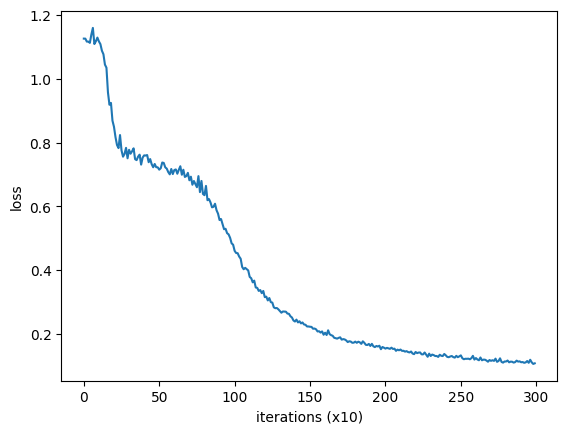

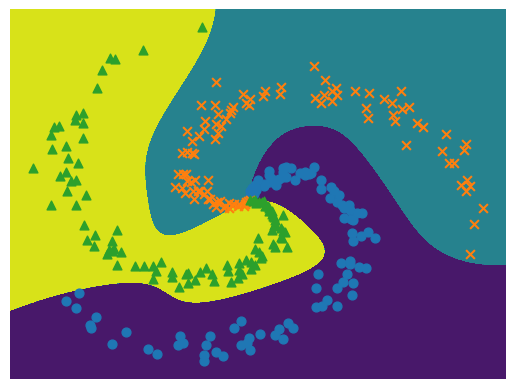

In [14]:
# coding: utf-8
import sys

sys.path.append(r"C:\Users\jiwon\OneDrive\Desktop\deep-learning-from-scratch-2-master")  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
from common.optimizer import SGD
from dataset import spiral
import matplotlib.pyplot as plt

# from two_layer_net import TwoLayerNet


# ハイパーパラメータの設定
max_epoch = 300
batch_size = 30
hidden_size = 10
learning_rate = 1.0

x, t = spiral.load_data() # x(300, 2):横座標と縦座標, t(300, 3):３つのクラス
model = TwoLayerNet(input_size=2, hidden_size=hidden_size, output_size=3)
optimizer = SGD(lr=learning_rate)

# 学習で使用する変数
data_size = len(x)
max_iters = data_size // batch_size # 1エポック
total_loss = 0
loss_count = 0
loss_list = []

for epoch in range(max_epoch): # 設定のエポック数まで試行
    # データのシャッフル
    idx = np.random.permutation(data_size) # ランダムなインデックス要素を含むリストを生成
    x = x[idx]
    t = t[idx]

    for iters in range(max_iters): # 1エポック間
        batch_x = x[iters * batch_size : (iters + 1) * batch_size] # e.g.x[0:30]
        batch_t = t[iters * batch_size : (iters + 1) * batch_size] # e.g.t[0:30]

        # 損失計算、勾配を求め、パラメータを更新(学習)
        loss = model.forward(batch_x, batch_t) # 前伝播
        model.backward() # 逆伝播
        optimizer.update(model.params, model.grads)

        # 後で損失平均を経過報告するために記録
        total_loss += loss
        loss_count += 1

        # １エポック分完了時の学習経過を出力
        if (iters + 1) % 10 == 0:
            avg_loss = total_loss / loss_count
            print("| epoch %d |  iter %d / %d | loss %.2f" % (epoch + 1, iters + 1, max_iters, avg_loss))
            loss_list.append(avg_loss) # 後でプロット描写のために記録
            total_loss, loss_count = 0, 0 # リセットしてまた１エポック分集計


# 学習結果のプロット
plt.plot(np.arange(len(loss_list)), loss_list, label="train") #エポックを横軸、その時の損失計算を縦軸
plt.xlabel("iterations (x10)")
plt.ylabel("loss")
plt.show()

# 境界領域のプロット
h = 0.001
x_min, x_max = x[:, 0].min() - 0.1, x[:, 0].max() + 0.1
y_min, y_max = x[:, 1].min() - 0.1, x[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
X = np.c_[xx.ravel(), yy.ravel()]
score = model.predict(X)
predict_cls = np.argmax(score, axis=1)
Z = predict_cls.reshape(xx.shape)
plt.contourf(xx, yy, Z)
plt.axis("off")

# データ点のプロット
x, t = spiral.load_data()
N = 100
CLS_NUM = 3
markers = ["o", "x", "^"]
for i in range(CLS_NUM):
    plt.scatter(x[i * N : (i + 1) * N, 0], x[i * N : (i + 1) * N, 1], s=40, marker=markers[i])
plt.show()


学習データ読み込みからモデル学習までの設定をするTrainerモジュール実装

In [31]:
# coding: utf-8
import sys
sys.path.append(r"C:\Users\jiwon\OneDrive\Desktop\deep-learning-from-scratch-2-master")  # 親ディレクトリのファイルをインポートするための設定
import numpy
import time
import matplotlib.pyplot as plt
# from common.np import *  # import numpy as np
from common.util import clip_grads


class Trainer:
    # 一番最初に使用するモデルとパラメータ更新法を設定
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.loss_list = [] # プロット描写用の記録
        self.eval_interval = None # 結果を表示する試行間隔（デフォルトでは設定なし：なしのままだと評価の出力されない）
        # self.current_epoch = 0

    # 学習の設定（エポック数、バッチサイズ、勾配のノルム最大値（これより小さくする）、結果を表示する試行間隔）
    def fit(self, x, t, max_epoch=10, batch_size=32, max_grad=None, eval_interval=20):
        data_size = len(x)
        max_iters = data_size // batch_size # １エポック
        self.eval_interval = eval_interval # 結果を表示する試行間隔
        model, optimizer = self.model, self.optimizer
        # 損失平均の途中経過出力のための記録用
        total_loss = 0
        loss_count = 0

        start_time = time.time()
        for epoch in range(max_epoch): # 設定のエポック数まで試行
            # ランダムなインデックス要素を含むリストを生成しその並びにデータを置き換える
            idx = numpy.random.permutation(numpy.arange(data_size))
            x = x[idx]
            t = t[idx]

            for iters in range(max_iters): # １エポックの間
                batch_x = x[iters*batch_size:(iters+1)*batch_size] # e.g. x[0:30]
                batch_t = t[iters*batch_size:(iters+1)*batch_size] # e.g. t[0:30]

                # 損失計算し、勾配を求め、パラメータを更新（学習）
                loss = model.forward(batch_x, batch_t)
                model.backward()
                # 下３行は今回のモデルTwoLayerNetでは適用しない(５章のRNNで使用)
                # 適用してもしなくても同じ結果
                # params, grads = remove_duplicate(model.params, model.grads)  # 共有された重みを1つに集約
                # if max_grad is not None:
                #     clip_grads(grads, max_grad)
                optimizer.update(model.params, model.grads)
                # 後で損失平均を経過出力するために記録
                total_loss += loss
                loss_count += 1

                # 評価
                # eval_intervalが設定されかつのその試行回数に達した時
                if (eval_interval is not None) and ((iters + 1) % eval_interval == 0):
                    avg_loss = total_loss / loss_count
                    elapsed_time = time.time() - start_time
                    print('| epoch %d |  iter %d / %d | time %d[s] | loss %.2f'
                          % (epoch + 1, iters + 1, max_iters, elapsed_time, avg_loss))
                    self.loss_list.append(float(avg_loss)) # プロット描写用に記録
                    total_loss, loss_count = 0, 0 #次の損失平均記録のためリセット

            # self.current_epoch += 1

    def plot(self, ylim=None):
        x = numpy.arange(len(self.loss_list)) # 経過出力回数を横軸
        if ylim is not None:
            plt.ylim(*ylim)
        plt.plot(x, self.loss_list, label='train') #その時の損失平均を縦軸
        plt.xlabel('iterations (x' + str(self.eval_interval) + ')')
        plt.ylabel('loss')
        plt.show()

# RNNのTrainerクラス（５章で扱う）
class RnnlmTrainer:
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.time_idx = None
        self.ppl_list = None
        self.eval_interval = None
        self.current_epoch = 0

    def get_batch(self, x, t, batch_size, time_size):
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')

        data_size = len(x)
        jump = data_size // batch_size
        offsets = [i * jump for i in range(batch_size)]  # バッチの各サンプルの読み込み開始位置

        for time in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, time] = x[(offset + self.time_idx) % data_size]
                batch_t[i, time] = t[(offset + self.time_idx) % data_size]
            self.time_idx += 1
        return batch_x, batch_t

    def fit(self, xs, ts, max_epoch=10, batch_size=20, time_size=35,
            max_grad=None, eval_interval=20):
        data_size = len(xs)
        max_iters = data_size // (batch_size * time_size)
        self.time_idx = 0
        self.ppl_list = []
        self.eval_interval = eval_interval
        model, optimizer = self.model, self.optimizer
        total_loss = 0
        loss_count = 0

        start_time = time.time()
        for epoch in range(max_epoch):
            for iters in range(max_iters):
                batch_x, batch_t = self.get_batch(xs, ts, batch_size, time_size)

                # 勾配を求め、パラメータを更新
                loss = model.forward(batch_x, batch_t)
                model.backward()
                # このメソッドの詳細は５章のRNNで
                params, grads = remove_duplicate(model.params, model.grads)  # 共有された重みを1つに集約
                if max_grad is not None:
                    clip_grads(grads, max_grad)
                optimizer.update(params, grads)
                total_loss += loss
                loss_count += 1

                # パープレキシティの評価
                if (eval_interval is not None) and (iters % eval_interval) == 0:
                    ppl = np.exp(total_loss / loss_count)
                    elapsed_time = time.time() - start_time
                    print('| epoch %d |  iter %d / %d | time %d[s] | perplexity %.2f'
                          % (self.current_epoch + 1, iters + 1, max_iters, elapsed_time, ppl))
                    self.ppl_list.append(float(ppl))
                    total_loss, loss_count = 0, 0

            self.current_epoch += 1

    def plot(self, ylim=None):
        x = numpy.arange(len(self.ppl_list))
        if ylim is not None:
            plt.ylim(*ylim)
        plt.plot(x, self.ppl_list, label='train')
        plt.xlabel('iterations (x' + str(self.eval_interval) + ')')
        plt.ylabel('perplexity')
        plt.show()


def remove_duplicate(params, grads):
    '''
    パラメータ配列中の重複する重みをひとつに集約し、
    その重みに対応する勾配を加算する
    '''
    params, grads = params[:], grads[:]  # copy list

    while True:
        find_flg = False
        L = len(params)

        for i in range(0, L - 1):
            for j in range(i + 1, L):
                # 重みを共有する場合
                if params[i] is params[j]:
                    grads[i] += grads[j]  # 勾配の加算
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)
                # 転置行列として重みを共有する場合（weight tying）
                elif params[i].ndim == 2 and params[j].ndim == 2 and \
                     params[i].T.shape == params[j].shape and np.all(params[i].T == params[j]):
                    grads[i] += grads[j].T
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)

                if find_flg: break
            if find_flg: break

        if not find_flg: break

    return params, grads


| epoch 1 |  iter 10 / 10 | time 0[s] | loss 1.13
| epoch 2 |  iter 10 / 10 | time 0[s] | loss 1.13
| epoch 3 |  iter 10 / 10 | time 0[s] | loss 1.12
| epoch 4 |  iter 10 / 10 | time 0[s] | loss 1.12
| epoch 5 |  iter 10 / 10 | time 0[s] | loss 1.11
| epoch 6 |  iter 10 / 10 | time 0[s] | loss 1.14
| epoch 7 |  iter 10 / 10 | time 0[s] | loss 1.16
| epoch 8 |  iter 10 / 10 | time 0[s] | loss 1.11
| epoch 9 |  iter 10 / 10 | time 0[s] | loss 1.12
| epoch 10 |  iter 10 / 10 | time 0[s] | loss 1.13
| epoch 11 |  iter 10 / 10 | time 0[s] | loss 1.12
| epoch 12 |  iter 10 / 10 | time 0[s] | loss 1.11
| epoch 13 |  iter 10 / 10 | time 0[s] | loss 1.09
| epoch 14 |  iter 10 / 10 | time 0[s] | loss 1.08
| epoch 15 |  iter 10 / 10 | time 0[s] | loss 1.04
| epoch 16 |  iter 10 / 10 | time 0[s] | loss 1.03
| epoch 17 |  iter 10 / 10 | time 0[s] | loss 0.96
| epoch 18 |  iter 10 / 10 | time 0[s] | loss 0.92
| epoch 19 |  iter 10 / 10 | time 0[s] | loss 0.92
| epoch 20 |  iter 10 / 10 | time 0[s] |

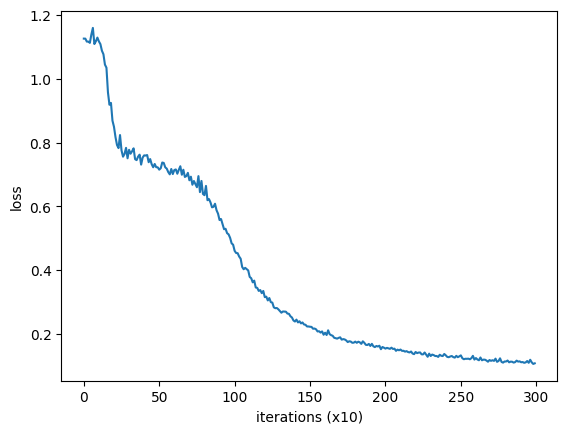

In [32]:
# coding: utf-8
import sys
sys.path.append(r"C:\Users\jiwon\OneDrive\Desktop\deep-learning-from-scratch-2-master")
from common.optimizer import SGD
# from common.trainer import Trainer
from dataset import spiral
# from two_layer_net import TwoLayerNet


# ハイパーパラメータの設定
max_epoch = 300
batch_size = 30
hidden_size = 10
learning_rate = 1.0

#データのロード
x, t = spiral.load_data()

# モデルの各レイヤのニューロン数設定しモデルのインスタンスを生成
model = TwoLayerNet(input_size=2, hidden_size=hidden_size, output_size=3)
# 学習法とその学習率係数を設定し学習法のインスタンスを生成
optimizer = SGD(lr=learning_rate)

# Trainerにモデルと学習法を渡す
trainer = Trainer(model, optimizer)
# Trainerの学習メソッドに学習設定（データ、試行エポック数、バッチサイズ、評価する試行間隔）を渡すと学習開始
trainer.fit(x, t, max_epoch, batch_size, eval_interval=10)
# 学習結果をプロット描写
trainer.plot()


In [17]:
for iters in range(10):
    print((iters ) % 10)
    if (iters ) % 10 == 0:
        print('iter %d / %d'% (iters + 1, 10))

0
iter 1 / 10
1
2
3
4
5
6
7
8
9


In [18]:
for iters in range(10):
    print((iters + 1) % 10)
    if (iters + 1) % 10 == 0:
        print('iter %d / %d'% (iters + 1, 10))

1
2
3
4
5
6
7
8
9
0
iter 10 / 10
